In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

In [2]:
from types import SimpleNamespace

paths = SimpleNamespace(
    summary="results/rnnprop_{}/summary.csv",
    config="results/rnnprop_{}/config.json",
    evaluation="results/rnnprop_{}/stage_{}/period_{}.json",
    baseline="results/adam.json"
)

In [3]:
def load_evaluation(*args):
    path = args[0] if len(args) == 1 else paths.evaluation.format(*args)
    with open(path) as f:
        df = pd.DataFrame(json.load(f))
    return df

In [4]:
def plot_training(test, title=""):
    df = pd.read_csv(paths.summary.format(test))
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    # df = df[df["stage"] < 3]
    for stage in df["stage"].unique():
        filtered = df[df["stage"] == stage]
        axs[0].plot(
            filtered["period"], filtered["validation_loss"],
            label="stage " + str(stage))
        axs[1].plot(
            filtered["period"], filtered["meta_loss_mean"],
            label="stage " + str(stage))
        axs[2].plot(
            filtered["period"], filtered["imitation_loss_mean"],
            label="stage " + str(stage))

        # eval_loss = [load_evaluation(test, stage, period)["loss"][24] for period in range(19)]
        # axs[2].plot(np.log(eval_loss), label="evaluation loss")
        # axs[1].scatter(np.log(eval_loss), filtered["validation_loss"][:19])

    axs[0].set_title("Validation Loss")
    axs[0].legend()
    # axs[0].set_ylim(-0.04, 0)

    # axs[1].set_ylim(-0.04, 0)
    axs[1].set_title("Training Meta Loss")
    axs[1].legend()

    axs[2].set_title("Training Imitation Loss")
    axs[2].legend()
    fig.suptitle(title)


In [5]:
def plot_evaluation(o1, o2=paths.baseline, name1="L2O", name2="Adam", title=""):

    o1 = o1 if isinstance(o1, list) else [o1]
    o2 = o2 if isinstance(o2, list) else [o2]
    df1 = load_evaluation(*o1)
    df2 = load_evaluation(*o2)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].plot(np.log(df1["loss"]), label=name1)
    axs[0].plot(np.log(df2["loss"]), label=name2)
    axs[0].legend()
    axs[0].set_title("Log training loss per epoch")

    axs[1].plot(df1["val_loss"], label=name1)
    axs[1].plot(df2["val_loss"], label=name2)
    axs[1].legend()
    axs[1].set_title("Validation loss per epoch")
    fig.suptitle(title)

In [6]:
def compare_set(ax, test, stage, periods=list(range(19)), title=None, label="loss", log=True):
    if title is None:
        title = test
    for period, color in zip(periods, plt.cm.jet(np.linspace(0, 1, len(periods)))):
        try:
            df = load_evaluation(test, stage, period)
            d = np.log(df[label]) if log else df[label]
            ax.plot(d, label="Period {}".format(period), color=color)
        except FileNotFoundError:
            pass
    adam = load_evaluation(paths.baseline)
    ax.plot(np.log(adam[label]) if log else adam[label], label="Adam")
    ax.set_ylabel(label)
    ax.set_xlabel("epoch")
    ax.legend()
    # ax.set_title(title)

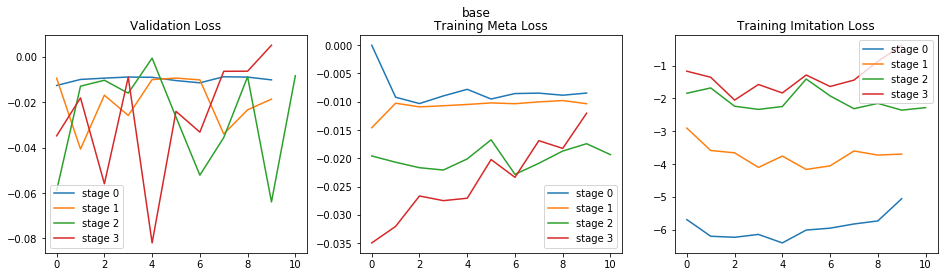

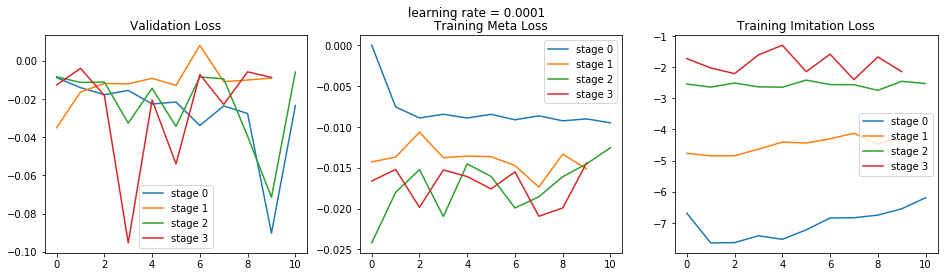

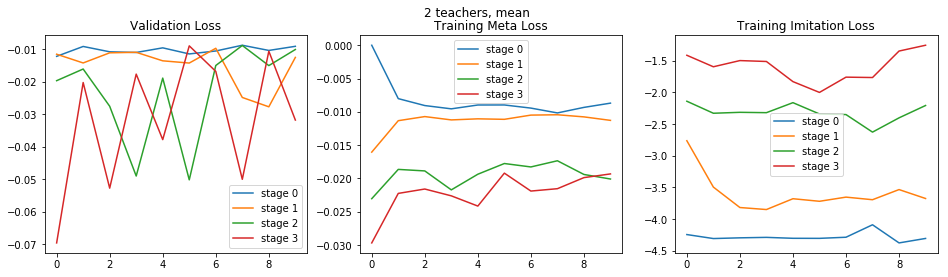

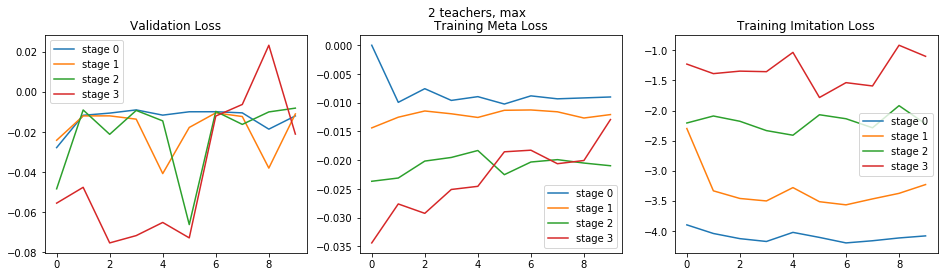

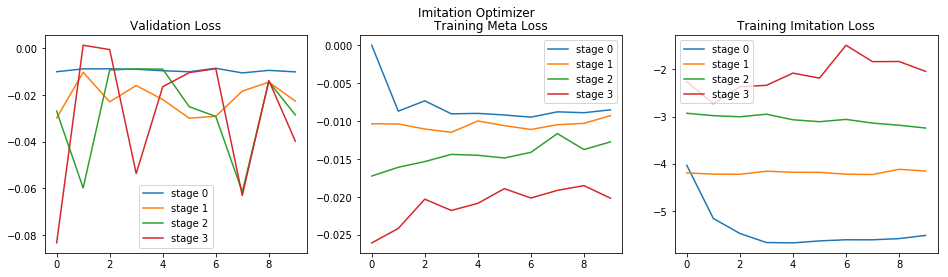

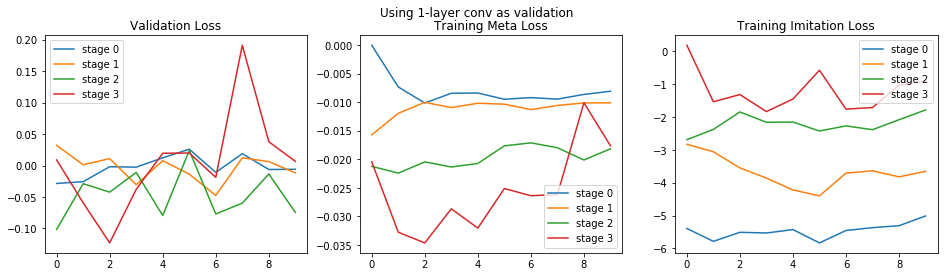

In [7]:
plot_training("0.1", title="base")
plot_training("small_lr", title="learning rate = 0.0001")
plot_training("2t", title="2 teachers, mean")
plot_training("2t_max", title="2 teachers, max")
plot_training("2opt", title="Imitation Optimizer")
plot_training("conv_validate", title="Using 1-layer conv as validation")

In [8]:
def _compare_stage(test, stage, **kwargs):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    compare_set(axs[0], test, stage, periods=list(range(4)), **kwargs)
    compare_set(axs[1], test, stage, periods=list(range(4, 7)), **kwargs)
    compare_set(axs[2], test, stage, periods=list(range(7, 10)), **kwargs)
    fig.suptitle(test)

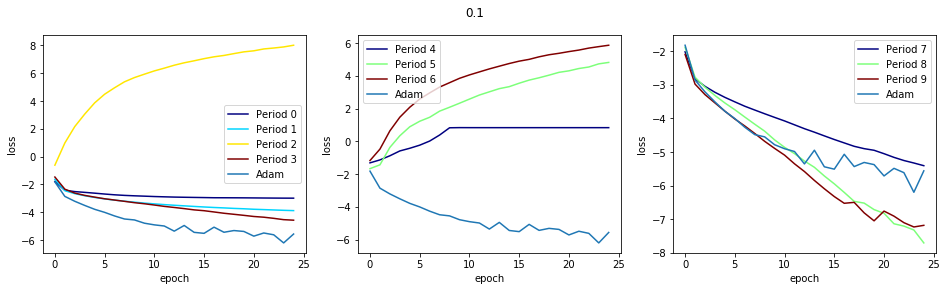

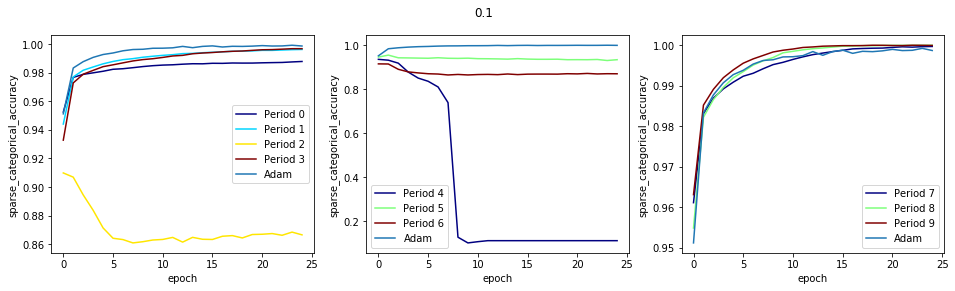

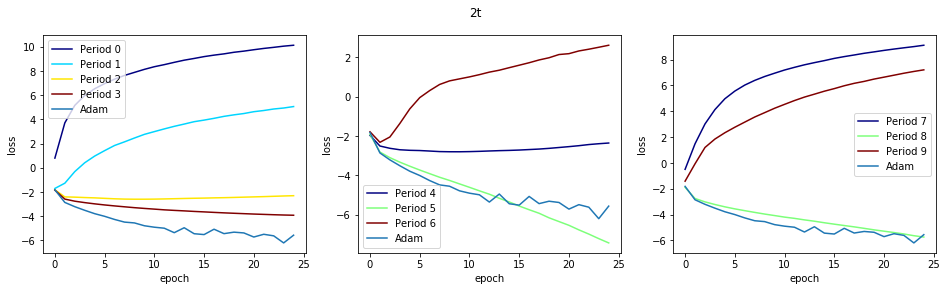

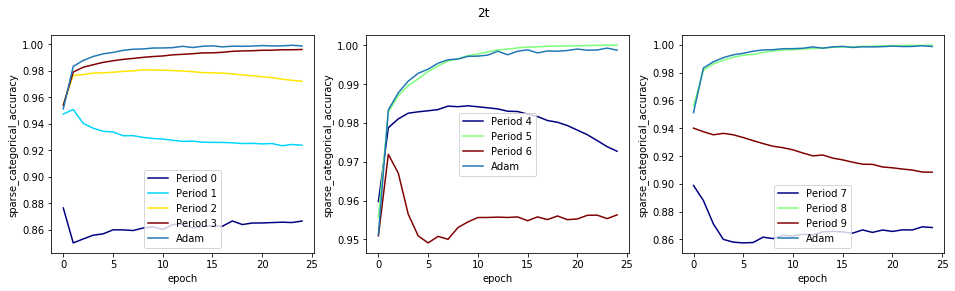

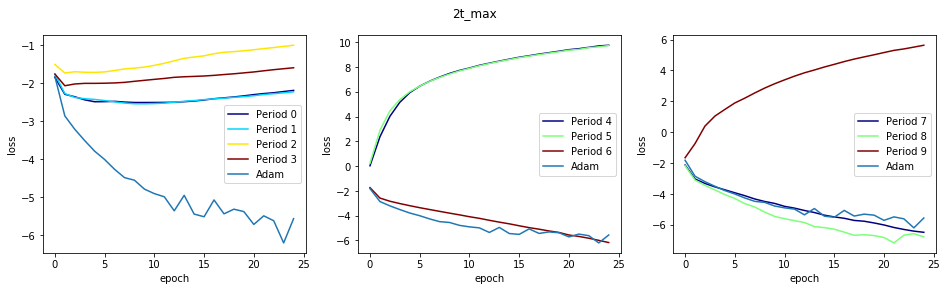

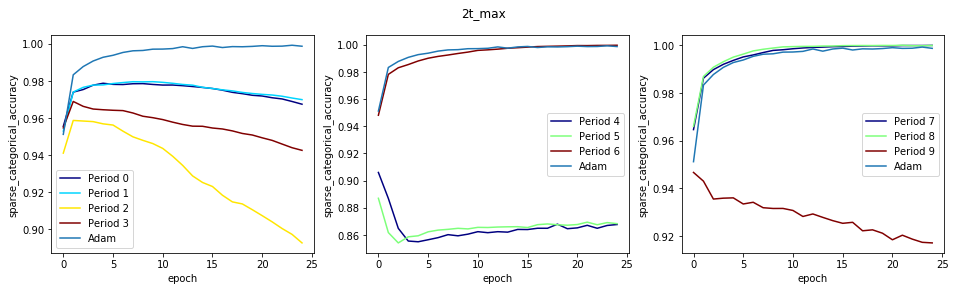

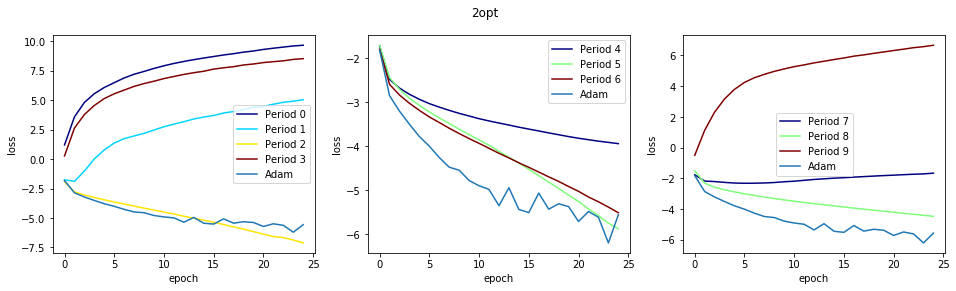

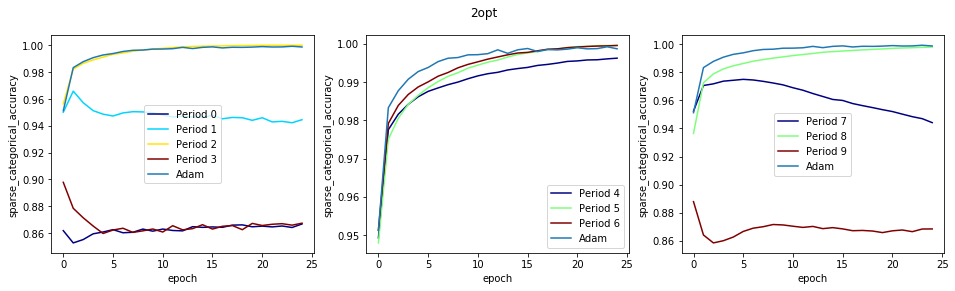

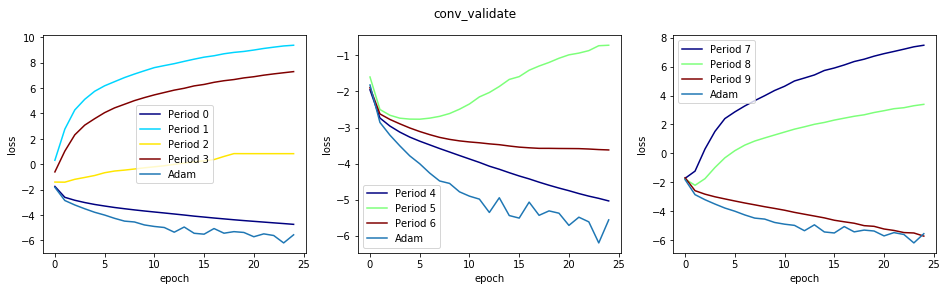

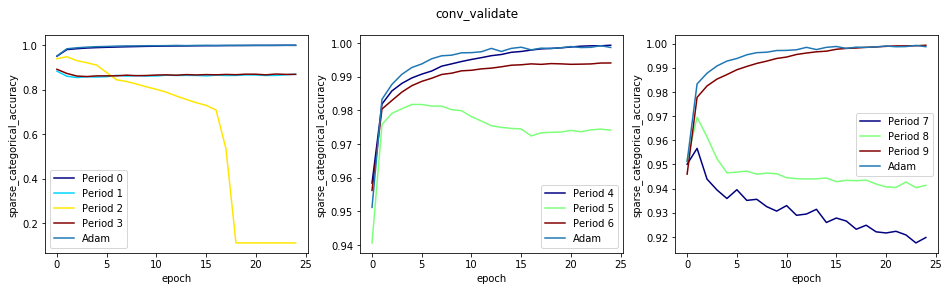

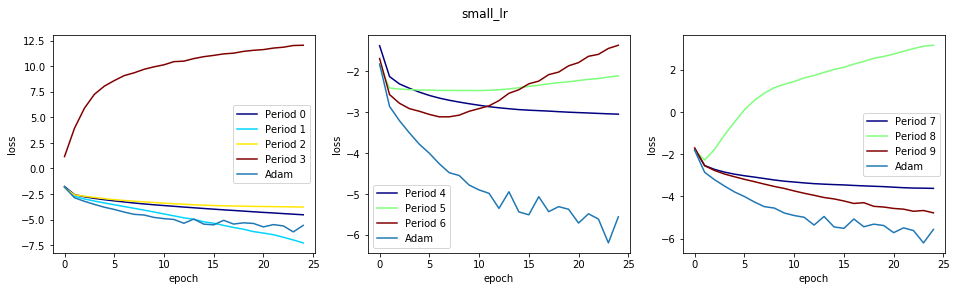

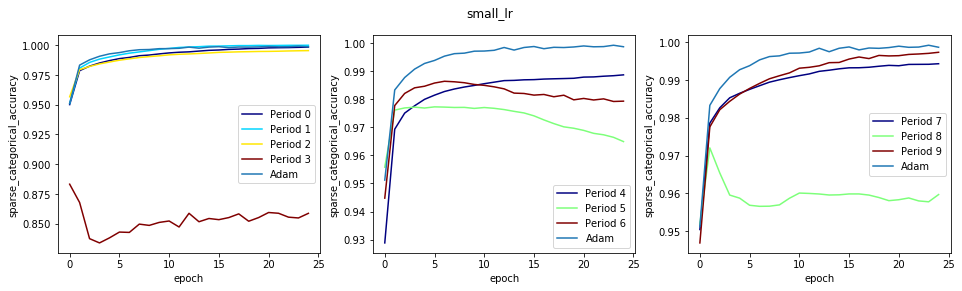

In [10]:
for test in ["0.1", "2t", "2t_max", "2opt", "conv_validate", "small_lr"]:
    _compare_stage(test, 3, label="loss")
    _compare_stage(test, 3, label="sparse_categorical_accuracy", log=False)

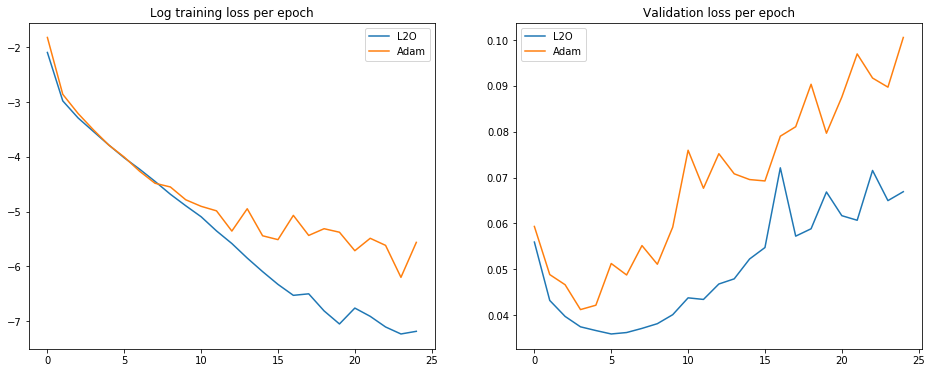

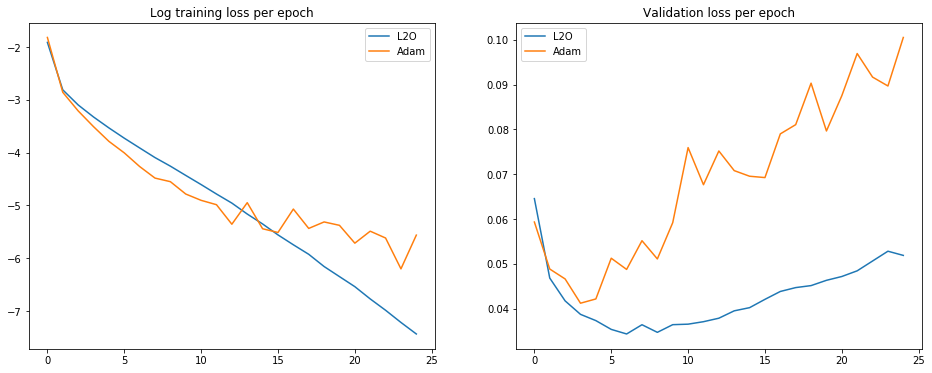

In [29]:
plot_evaluation(["0.1", 3, 9])
plot_evaluation(["2t", 3, 5])


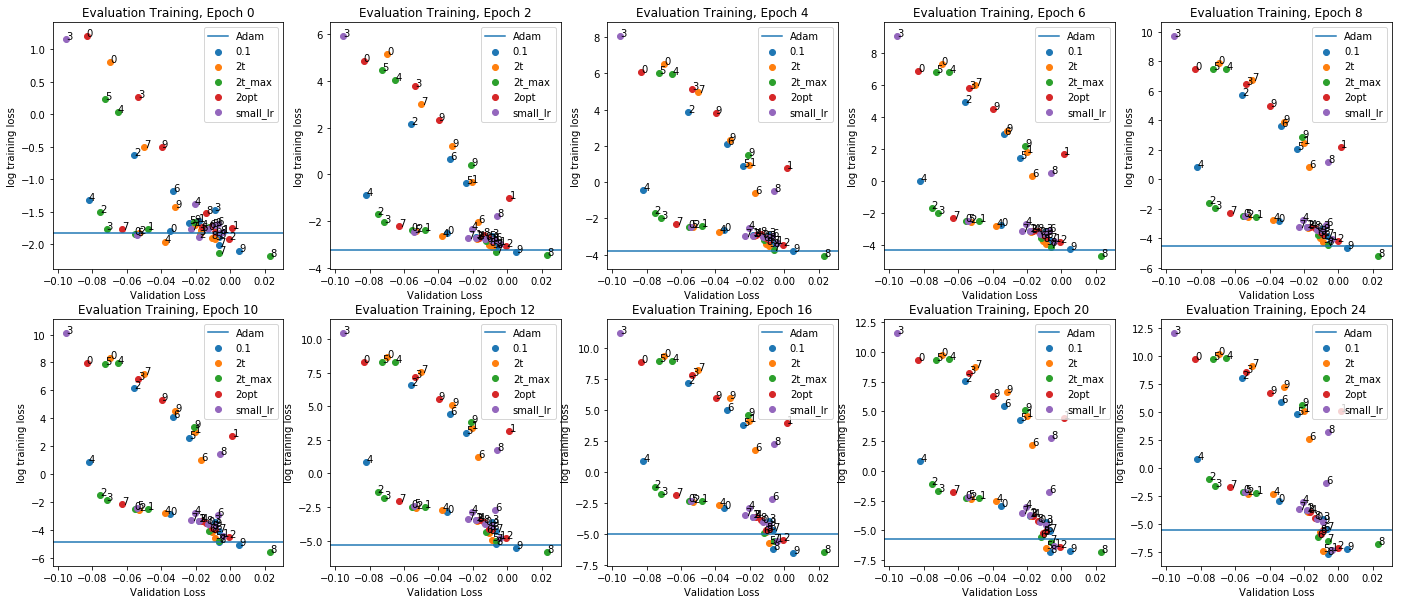

In [11]:
baseline = load_evaluation(paths.baseline)["loss"]

fig, axs = plt.subplots(2, 5, figsize=(24, 10))
for epoch, ax in zip([0, 2, 4, 6, 8, 10, 12, 16, 20, 24], [*axs[0], *axs[1]]):

    for test in ["0.1", "2t", "2t_max", "2opt", "small_lr"]:
        evaluation = [load_evaluation(test, 3, n)["loss"][epoch] for n in range(10)]
        df = pd.read_csv(paths.summary.format(test))
        validation = list(df[df["stage"] == 3]["validation_loss"])
        for n, v, e in zip(range(10), validation, np.log(evaluation)):
            ax.annotate(str(n), (v, e))
        ax.scatter(validation, np.log(evaluation), label=test)

    ax.axhline(np.log(baseline[epoch]), label="Adam")
    ax.set_xlabel("Validation Loss")
    ax.set_ylabel("log training loss")
    ax.set_title("Evaluation Training, Epoch {}".format(epoch))
    ax.legend()

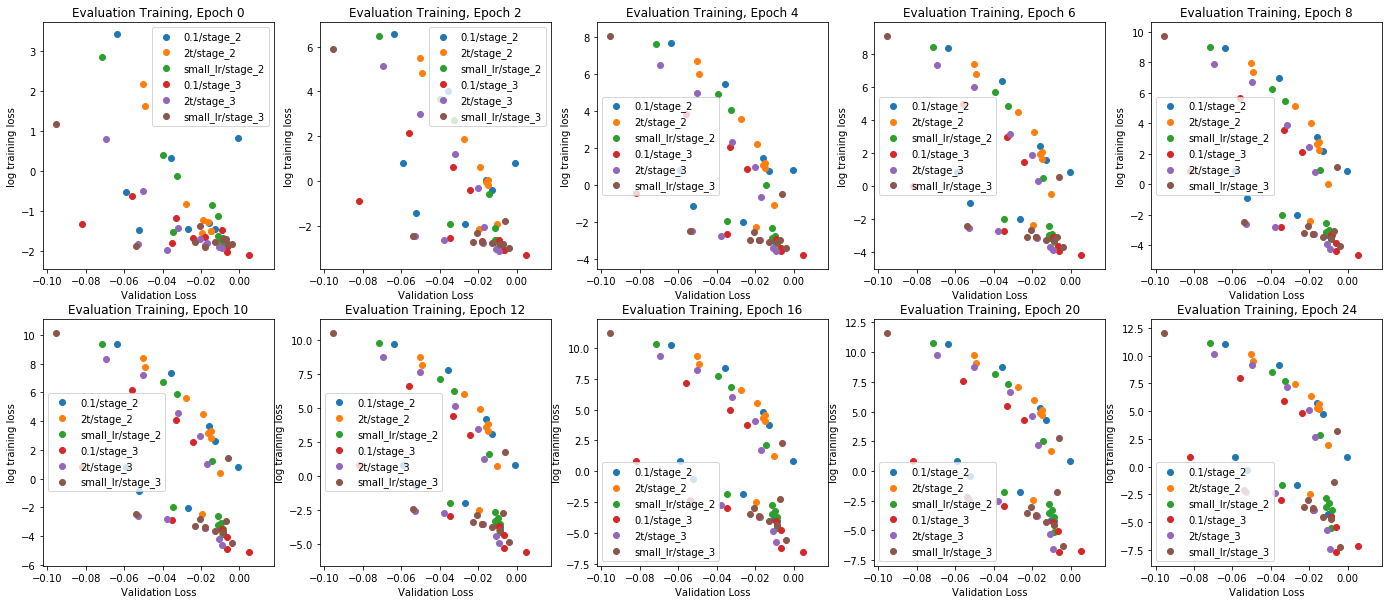

In [13]:
fig, axs = plt.subplots(2, 5, figsize=(24, 10))
for epoch, ax in zip([0, 2, 4, 6, 8, 10, 12, 16, 20, 24], [*axs[0], *axs[1]]):
    for stage in [2, 3]:
        for test in ["0.1", "2t", "small_lr"]:
            evaluation = [load_evaluation(test, stage, n)["loss"][epoch] for n in range(10)]
            df = pd.read_csv(paths.summary.format(test))
            validation = list(df[df["stage"] == stage]["validation_loss"])[:10]
            ax.scatter(validation, np.log(evaluation), label="{}/stage_{}".format(test, stage))
        ax.set_xlabel("Validation Loss")
        ax.set_ylabel("log training loss")
        ax.set_title("Evaluation Training, Epoch {}".format(epoch))
        ax.legend()

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for stage in [2, 3]:

    evaluation = [load_evaluation("conv_validate", stage, n)["loss"][24] for n in range(10)]
    df = pd.read_csv(paths.summary.format(test))
    validation = list(df[df["stage"] == stage]["validation_loss"])

    for n, v, e in zip(range(10), validation, np.log(evaluation)):
        ax.annotate(str(n), (v, e))

    ax.scatter(validation, np.log(evaluation), label=str(stage))

    ax.set_xlabel("Validation Loss")
    ax.set_ylabel("log training loss")
    ax.set_title("Evaluation Training, Epoch 24")


ValueError: x and y must be the same size

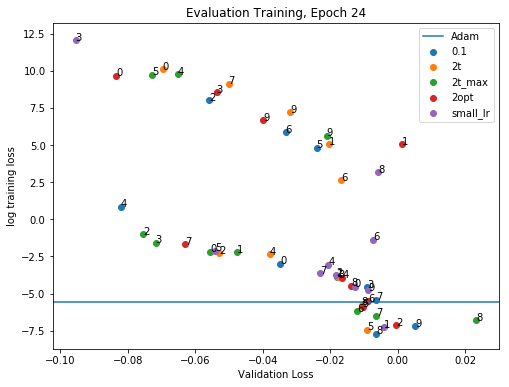

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for test in ["0.1", "2t", "2t_max", "2opt", "small_lr"]:

    evaluation = [load_evaluation(test, 3, n)["loss"][24] for n in range(10)]
    df = pd.read_csv(paths.summary.format(test))
    validation = list(df[df["stage"] == 3]["validation_loss"])

    for n, v, e in zip(range(10), validation, np.log(evaluation)):
        ax.annotate(str(n), (v, e))

    ax.scatter(validation, np.log(evaluation), label=test)

ax.axhline(np.log(baseline[epoch]), label="Adam")
ax.set_xlabel("Validation Loss")
ax.set_ylabel("log training loss")
ax.set_title("Evaluation Training, Epoch 24")
ax.legend()